In [1]:
import pathlib

import open3d as o3d
import copy

from pin_segment import RgbdPinFetcher, SfMPinFetcher
import linear_algebra as util_la
from pin_center import find_pin_center
from icp_align import (
    paint_pcd_binary, 
    find_pin_nbr, iter_rotation_angle,
    color_based_icp, draw_registration_result,
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dataset_root = pathlib.Path(r'/home/crest/w/hwang_Pro/datasets/3DPotatoTwin')
pin_ref_folder = pathlib.Path(r'/home/crest/Documents/Github/PotatoScan/3dscan/03_sfm_rgbd_registration/pin_ref')

rgbd_fetcher = RgbdPinFetcher(dataset_root)
sfm_fetcher = SfMPinFetcher(dataset_root, pin_ref_folder)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


In [3]:
pid = "R3-6"   # the most challenging one

In [4]:
rgbd_data = rgbd_fetcher.get(pid, visualize=True, show=False)
sfm_data = sfm_fetcher.get(pid, visualize=True, show=False)

:: iterative pin segmentation of SfM point clouds
    Stop at thresh=0.35 with hull volume = 57.188190396365265


In [5]:
sfm_pin_data = find_pin_center(
    sfm_data['pin_pcd'], sfm_data['pcd'], 
    circle_color=[0,0,0], visualize=True, show=False
)
rgbd_pin_data = find_pin_center(
    rgbd_data['pin_pcd'], rgbd_data['pcd'], 
    circle_color=[0,0,0], visualize=True, show=False
)

:: Correct pin vector direction
   st = 0.024901174005667586 | ed = 0.014901174005667582 | min = 1.2415446172748049e-07 | max = 0.029283734496958865
   pin vector from [ 0.61102944 -0.79132896  0.02101178] to [-0.61102944  0.79132896 -0.02101178]
:: Correct pin vector direction
   st = 0.25770188048842807 | ed = 0.2677018804884281 | min = 0.2548788070821822 | max = 0.29218905216898905
   pin vector from [0.22409537 0.37634412 0.89896961] to [-0.22409537 -0.37634412 -0.89896961]


In [6]:
search_radius = 0.03
# find the pin neighbour of sfm
sfm_nbr_data = find_pin_nbr(sfm_data, sfm_pin_data, search_radius, visualize=True)
rgbd_nbr_data = find_pin_nbr(rgbd_data, rgbd_pin_data, search_radius, visualize=True)


   st = 0.020949592372143482 | ed = 0.010949592372143482 | min = 4.704072875498511e-07 | max = 0.033225845158599554
   st = 0.29863164844752965 | ed = 0.30863164844752966 | min = 0.2953650603446097 | max = 0.32104259005896396


In [8]:
sfm_nbr_data.keys()

dict_keys(['nbr_pcd', 'nbr_idx', 'nbr_radius', 'nbr_vector', 'vector_arrow'])

In [7]:
o3d.visualization.draw_geometries([sfm_nbr_data['nbr_pcd']])

Get vertex and uv

In [10]:
u,v = util_la.calculate_normal_uv(sfm_pin_data['vector'])

u,v

(array([ 0.        , -0.02654317, -0.99964767]),
 array([-0.79160787, -0.61081415,  0.01621866]))

Obtain the cross section

:: input ::

pcd, pin_center, pin_vector, pin_u, pin_v, buffer

:: Step ::

1. Calculate distance from pcd to (pin_u, pin_center) plane
2. filter the distance by buffer threshold
3. Get the above u_id
4. Repeat to get the v_id
5. Merge u_id and v_id to get the cross id -> uv_id  -> cross_pcd

Redo for the rgbd -> uv_id  -> cross_pcd

Then do the ICP for the cross_pcd pairs

In [11]:
import numpy as np

In [15]:
def point_to_plane_distance(points, plane_point, plane_normal):
    # 计算向量点乘以及法向量的长度
    # dot_product = np.dot(plane_normal, (points - plane_point))
    # norm = np.linalg.norm(plane_normal)
    # 计算距离并返回
    #  distance = abs(dot_product) / norm
    # 计算每个点到平面的距离
    distances = np.abs(np.dot(points - plane_point, plane_normal)) / np.linalg.norm(plane_normal)
    return distances

In [17]:
dist = point_to_plane_distance(np.asarray(sfm_nbr_data['nbr_pcd'].points), sfm_pin_data['circle_center_3d'], u)
dist

array([0.0004157 , 0.02178582, 0.01554094, ..., 0.00431118, 0.02203924,
       0.01305756])

In [18]:
buffer = 0.0025 # 5mm buffer

In [21]:
u_id = np.where(dist < buffer)[0]

In [22]:
u_pcd = sfm_nbr_data['nbr_pcd'].select_by_index(u_id)

In [23]:
o3d.visualization.draw_geometries([u_pcd])

repeat for v_id

In [26]:
dist_u = point_to_plane_distance(np.asarray(sfm_nbr_data['nbr_pcd'].points), sfm_pin_data['circle_center_3d'], u)
u_id = np.where(dist_u < buffer)[0]
dist_v = point_to_plane_distance(np.asarray(sfm_nbr_data['nbr_pcd'].points), sfm_pin_data['circle_center_3d'], v)
v_id = np.where(dist_v < buffer)[0]

uv_id = np.unique(np.concatenate((u_id, v_id),0))
uv_pcd = sfm_nbr_data['nbr_pcd'].select_by_index(uv_id)

In [27]:
o3d.visualization.draw_geometries([uv_pcd])

In [33]:
def get_nbr_cross(pcd, plane_point, plane_normal, buffer):
    points = np.asarray(pcd.points)
    u,v = util_la.calculate_normal_uv(plane_normal)

    dist_u = point_to_plane_distance(points, plane_point, u)
    u_id = np.where(dist_u < buffer)[0]
    dist_v = point_to_plane_distance(points, plane_point, v)
    v_id = np.where(dist_v < buffer)[0]

    uv_id = np.unique(np.concatenate((u_id, v_id),0))
    uv_pcd = pcd.select_by_index(uv_id)
    return uv_pcd, uv_id

In [37]:
sfm_nbr_cross_pcd, sfm_uv_id = get_nbr_cross(
    sfm_nbr_data['nbr_pcd'], 
    sfm_pin_data['circle_center_3d'],
    sfm_pin_data['vector'],
    buffer=0.001
)

In [35]:
o3d.visualization.draw_geometries([sfm_nbr_cross_pcd])

repeat for rgbd_pcd

In [38]:
rgbd_nbr_cross_pcd, rgbd_uv_id = get_nbr_cross(
    rgbd_nbr_data['nbr_pcd'], 
    rgbd_pin_data['circle_center_3d'],
    rgbd_pin_data['vector'],
    buffer=0.001
)

In [41]:
o3d.visualization.draw_geometries([sfm_nbr_cross_pcd, rgbd_nbr_cross_pcd])

Redo for the pin_matched pcd

In [42]:
imatrix =  util_la.create_rotational_transform_matrix(
    rgbd_pin_data['circle_center_3d'], rgbd_pin_data['vector'],
    sfm_pin_data['circle_center_3d'], sfm_pin_data['vector'],
)

In [43]:
rgbd_data_it = {}
rgbd_data_it['pcd'] = copy.deepcopy(rgbd_data['pcd']).transform(imatrix)
rgbd_data_it['pin_idx'] = rgbd_data['pin_idx']
rgbd_data_it['pin_pcd'] = rgbd_data_it['pcd'].select_by_index(rgbd_data['pin_idx'])

rgbd_pin_data_it = find_pin_center(
    rgbd_data_it['pin_pcd'], rgbd_data_it['pcd'], 
    circle_color=[0,0,0], visualize=True, show=False
)
# find the pin neighbor of rgbd
rgbd_nbr_data_it = find_pin_nbr(rgbd_data_it, rgbd_pin_data_it, radius= search_radius)

:: Correct pin vector direction
   st = 0.02490117400566914 | ed = 0.014901174005669137 | min = 1.5968594014028825e-06 | max = 0.027724247411914746
   pin vector from [ 0.61102944 -0.79132896  0.02101178] to [-0.61102944  0.79132896 -0.02101178]
   st = 0.02124887758114945 | ed = 0.03124887758114945 | min = 2.8272586289875354e-07 | max = 0.024529412427149757


In [44]:
rgbd_nbr_cross_pcd, rgbd_uv_id = get_nbr_cross(
    rgbd_nbr_data_it['nbr_pcd'], 
    rgbd_pin_data_it['circle_center_3d'],
    rgbd_pin_data_it['vector'],
    buffer=0.001
)

In [45]:
o3d.visualization.draw_geometries([sfm_nbr_cross_pcd, rgbd_nbr_cross_pcd])

DO ICP?

In [64]:
def shape_based_icp(
        source_binary_pcd, target_binary_pcd, initial_matrix=np.eye(4), 
        voxel_size=0.001, threshold=0.002, max_iter=2000
    ):
    """_summary_

    Parameters
    ----------
    source_binary_pcd : o3d.PointCloud
        rgbd point cloud
    target_binary_pcd : o3d.PointCloud
        sfm point cloud
    voxel_size : float, optional
        the size for voxel downsampling, by default 0.001
    color_weight : float, optional
        the weight of color vs geometry, from 0 to 1, by default 0.7
    threshold: float, optional
        the distance? threshold to stop ICP align iterations, by default 0.002 (2mm)


    Note
    ----
    By passing initial_matrix to `registration_colored_icp` gives a different (worse) results 
    than transforming first and then icp, and finally multiple two matrix together
    """
    source_binary_pcd_t = copy.deepcopy(source_binary_pcd).transform(initial_matrix)

    source_pcd_down = source_binary_pcd_t.voxel_down_sample(voxel_size)
    target_pcd_down = target_binary_pcd.voxel_down_sample(voxel_size)

    source_pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2, max_nn=30))
    target_pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2, max_nn=30))
    
    result_icp = o3d.pipelines.registration.registration_icp(
        source_pcd_down, target_pcd_down, threshold, initial_matrix,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
    
    return result_icp

In [65]:
result_icp = shape_based_icp(rgbd_nbr_cross_pcd, sfm_nbr_cross_pcd, )

print(result_icp.fitness, result_icp.inlier_rmse, result_icp.transformation)

0.6590038314176245 0.0010250523844085064 [[ 9.89819712e-01  1.42324730e-01 -7.80646665e-04 -3.68209436e-03]
 [-1.41838869e-01  9.86864855e-01  7.73271865e-02 -8.63406366e-03]
 [ 1.17759637e-02 -7.64292474e-02  9.97005465e-01  2.42869892e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [50]:
from icp_align import draw_registration_result

In [66]:
draw_registration_result(rgbd_nbr_cross_pcd, sfm_nbr_cross_pcd, result_icp.transformation, show=True)

Rotate the rgbd_pin by x degrees

In [104]:
rotate_point, rotate_axis = rgbd_pin_data_it['circle_center_3d'], rgbd_pin_data_it['vector']
source_pcd = rgbd_nbr_data_it['nbr_pcd']

rmses = []
angles = []
matrix = []

for angle in range(1, 36):

    rot_matrix = util_la.rotation_matrix_around_vector(rotate_axis, rotate_point, angle*10)
    # rgbd -> to rotate
    source_rot_vector_pcd = copy.deepcopy(source_pcd).transform(rot_matrix)
    # source_rot_vector_pcd.paint_uniform_color([1,0,0])

    rgbd_nbr_cross_pcd, rgbd_uv_id = get_nbr_cross(
        source_rot_vector_pcd, 
        rgbd_pin_data_it['circle_center_3d'],
        rgbd_pin_data_it['vector'],
        buffer=0.001
    )

    result_icp = shape_based_icp(rgbd_nbr_cross_pcd, sfm_nbr_cross_pcd)

    rmses.append(result_icp.inlier_rmse)
    matrix.append(result_icp.transformation)
    angles.append(angle * 10)

    print(f"- Rotate {angle * 10} | RMSE={result_icp.inlier_rmse}")

    # draw_registration_result(rgbd_nbr_cross_pcd, sfm_nbr_cross_pcd, result_icp.transformation, show=True)

- Rotate 10 | RMSE=0.0009641531671149884
- Rotate 20 | RMSE=0.0009339566691478299
- Rotate 30 | RMSE=0.0009793902784339904
- Rotate 40 | RMSE=0.0009262592182669283
- Rotate 50 | RMSE=0.0010974628749871457
- Rotate 60 | RMSE=0.0009524177526895619
- Rotate 70 | RMSE=0.000849496977301255
- Rotate 80 | RMSE=0.0008519435061266378
- Rotate 90 | RMSE=0.0009204830922290697
- Rotate 100 | RMSE=0.001045573535726833
- Rotate 110 | RMSE=0.0011096187338223516
- Rotate 120 | RMSE=0.0010703923111362822
- Rotate 130 | RMSE=0.0010267566420141942
- Rotate 140 | RMSE=0.0011244488665634325
- Rotate 150 | RMSE=0.001010245501644322
- Rotate 160 | RMSE=0.0010969555557217906
- Rotate 170 | RMSE=0.0009555370266250391
- Rotate 180 | RMSE=0.0009272736825653074
- Rotate 190 | RMSE=0.0009054446384633061
- Rotate 200 | RMSE=0.0009171453007197165
- Rotate 210 | RMSE=0.0010178285211603732
- Rotate 220 | RMSE=0.0008302129371823055
- Rotate 230 | RMSE=0.0008861597236813509
- Rotate 240 | RMSE=0.000885183996859965
- Rot

In [94]:
angles = np.asarray(angles)
rmses = np.asarray(rmses)

# find the minimum values
best_angle = angles[np.argmin(rmses)]
best_rot_matrix = matrix[np.argmin(rmses)]

In [73]:
import matplotlib.pyplot as plt

220

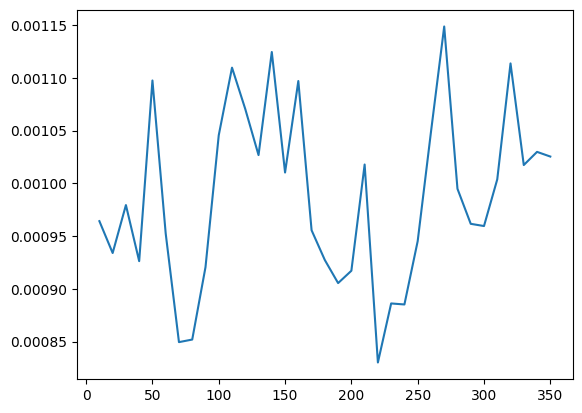

In [95]:
plt.plot(angles, rmses)
best_angle

In [99]:
best_angle = angles[6]
best_rot_matrix = matrix[6]
rmse = rmses[6]

best_angle, rmse

(70, 0.0008494969773012541)

In [102]:
rot_matrix = util_la.rotation_matrix_around_vector(rotate_axis, rotate_point, best_angle)
# rgbd -> to rotate
# source_rot_vector_pcd = copy.deepcopy(source_pcd).transform(best_rot_matrix @ rot_matrix)
# source_rot_vector_pcd = copy.deepcopy(source_pcd).transform(best_rot_matrix)
source_rot_vector_pcd = copy.deepcopy(source_pcd).transform(rot_matrix)

In [103]:
o3d.visualization.draw_geometries([sfm_data['pcd'], source_rot_vector_pcd])